# What is Malware

1. What is malware

  * Based on vendors classification, min threshold

2. Choose top vendors

  * Given the previous threshold, vendors with higher DR
  * Validate the previous threshold holds statistically
3. Classifier

  * DLL imports as features
  
  * Reduce number of features
  
  * Unbalanced dataset
  
  * Balance dataset
  
  * Baseline classifier
  
  * Temporal consistency classifier
  
To obtain a model to detect malware, one must first define what is malware and what is not. This first step is not trivial, as malware is defined subjectively, hence vendors don't always agree on what is malware.

Regarding goodware samples, the defining criteria is that no vendor classifies a sample as malware (some may not classify it, but all that do must classify as clean).

In [1]:
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_folder = '../data/'
vendors_file = data_folder + 'vendors.csv.gz'
reports_file = data_folder + 'reports.csv.gz'

In [2]:
# Contains all header information
reports = pd.read_csv(reports_file)
reports = reports.set_index('link')
# Sanity check
assert len(reports[~reports.file_type.str.startswith('PE32')]) == 0
reports.drop(['file_name', 'file_size', 'file_type'], axis=1, inplace=True)
reports.date = pd.to_datetime(reports.date, infer_datetime_format=True)
# Now it contains:
# reports = (link, md5, date)

# Contains link as vendors classification
vendors = pd.read_csv(vendors_file, dtype=str)
vendors = vendors.set_index('link')
vendors.dropna(how='all', inplace=True)

# Joins on link
# reports_vendors = (link, md5, date, ..vendors..)
reports_vendors = reports.join(vendors, how='inner')

## Classification Statistics

We start by looking at some statistics regarding samples' classification. Specifically how many of the total samples are classified, how many samples each vendor classifies and how many duplicated samples there are.

### Classified samples

In [3]:
display('{} classified samples from a total of {} ({:.2f}%)'.format(
    len(vendors), len(reports), 100*len(vendors)/len(reports)))

'292127 classified samples from a total of 397436 (73.50%)'

### Size of classified samples for each vendor

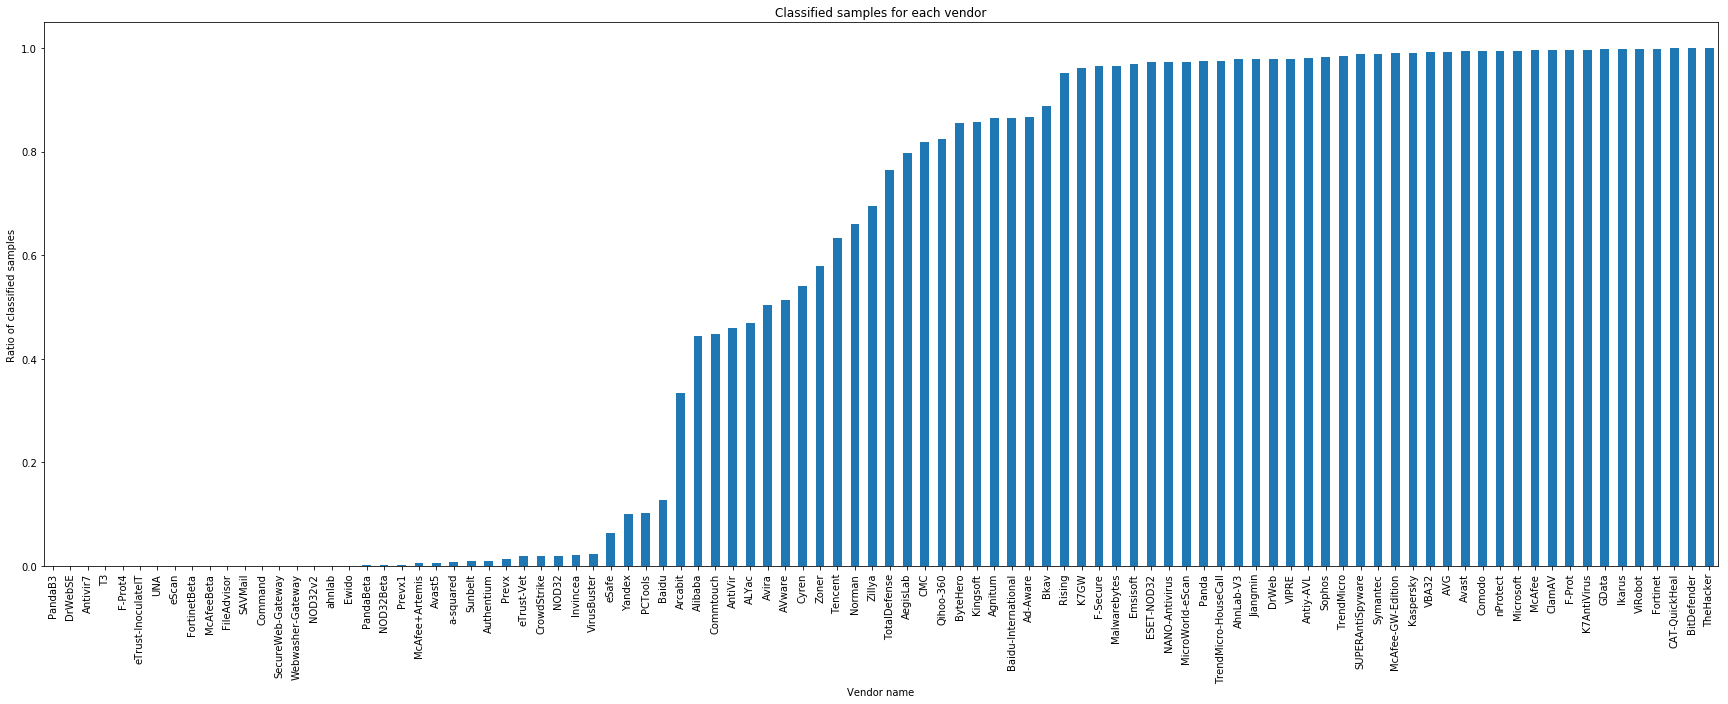

In [4]:
vendors_presence = pd.Series(
    index=reports_vendors.columns[2:],
    data=[reports_vendors[vendor].count() for vendor in reports_vendors.columns[2:]])

ax3 = vendors_presence.sort_values().divide(len(reports_vendors)).plot.bar(
    figsize=((30, 10)),
    title='Classified samples for each vendor')
ax3.set_xlabel('Vendor name')
ax3.set_ylabel('Ratio of classified samples')
plt.show()

### Duplicated samples

In [5]:
# MD5 of duplicated samples
md5_dups = set(reports_vendors[reports_vendors.md5.duplicated()].md5)
total_dups = len(reports_vendors[reports_vendors.md5.isin(md5_dups)])
display('{} duplicated samples from a total of {} ({:.2f}%)'.format(
    total_dups, len(reports_vendors), 100*total_dups/len(reports_vendors)))
display('{} duplicated md5\'s (~{:.2f} submissions per sample)'.format(
    len(md5_dups), total_dups/len(md5_dups)))

'78451 duplicated samples from a total of 292127 (26.86%)'

"28996 duplicated md5's (~2.71 submissions per sample)"

### Size of duplicated classified samples for each vendor

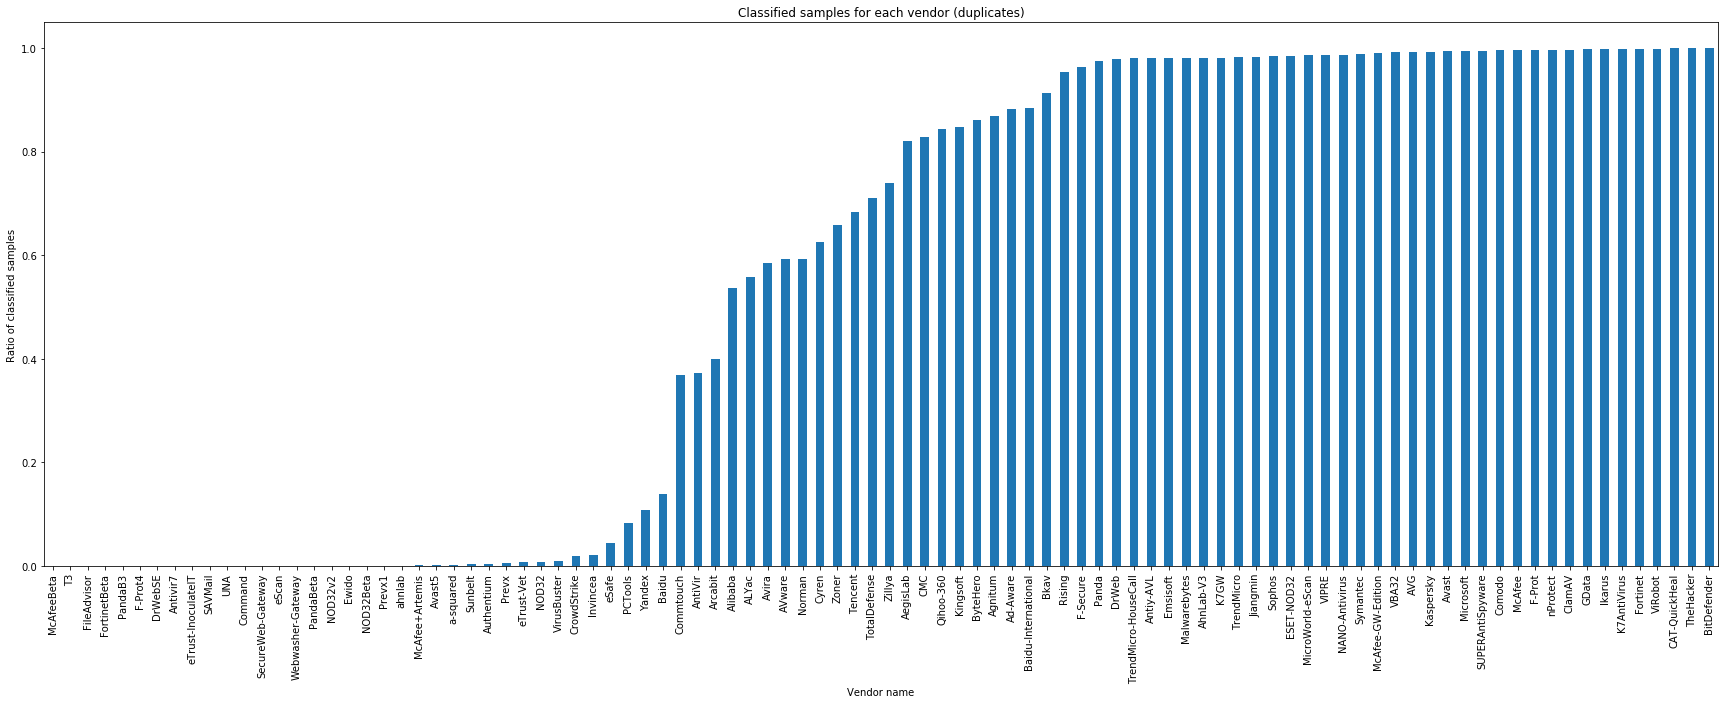

In [6]:
vendors_presence_dups = pd.Series(
    index=reports_vendors.columns[2:],
    data=[reports_vendors[vendor][reports_vendors.md5.isin(md5_dups)].count() for vendor in reports_vendors.columns[2:]])

ax3 = vendors_presence_dups.sort_values().divide(len(reports_vendors[reports_vendors.md5.isin(md5_dups)])).plot.bar(
    figsize=((30, 10)),
    title='Classified samples for each vendor (duplicates)')
ax3.set_xlabel('Vendor name')
ax3.set_ylabel('Ratio of classified samples')
plt.show()

## Classification difference

By understanding how each sample classification varies between the last and final submission one can arrive at a minimum threshold needed to classify a sample as malware.

In [7]:
# Generate frame with first and last submission of duplicated samples
first_last_samples = pd.concat([
    reports_vendors[reports_vendors.md5.isin(md5_dups)].drop_duplicates(keep='first', subset='md5'),
    reports_vendors[reports_vendors.md5.isin(md5_dups)].drop_duplicates(keep='last', subset='md5')])
# Fill 'Clean' as NaN, we just care about classified samples for counting
first_last_samples.replace('Clean', np.nan, inplace=True)
# Group submissions of the sample sample, count the number of classifications
first_last_samples = first_last_samples.groupby(['md5', 'date']).count().sum(axis=1).reset_index('date')

In [8]:
%%time
# Calculate the difference between last and first submission
differences = []
for md5 in first_last_samples.index.unique():
    temp = first_last_samples[first_last_samples.index == md5].sort_values('date', ascending=False)
    temp = temp[0].values
    differences += [temp[0] - temp[1]]

CPU times: user 3min 8s, sys: 131 ms, total: 3min 8s
Wall time: 3min 8s


In [9]:
differences_count = pd.Series(differences).value_counts().sort_index()
display('{}/{} ({:.2f}%) samples changed classification.'.format(
    differences_count[differences_count.index != 0].sum(),
    differences_count.sum(),
    100*differences_count[differences_count.index != 0].sum()/differences_count.sum()))

'12507/28996 (43.13%) samples changed classification.'

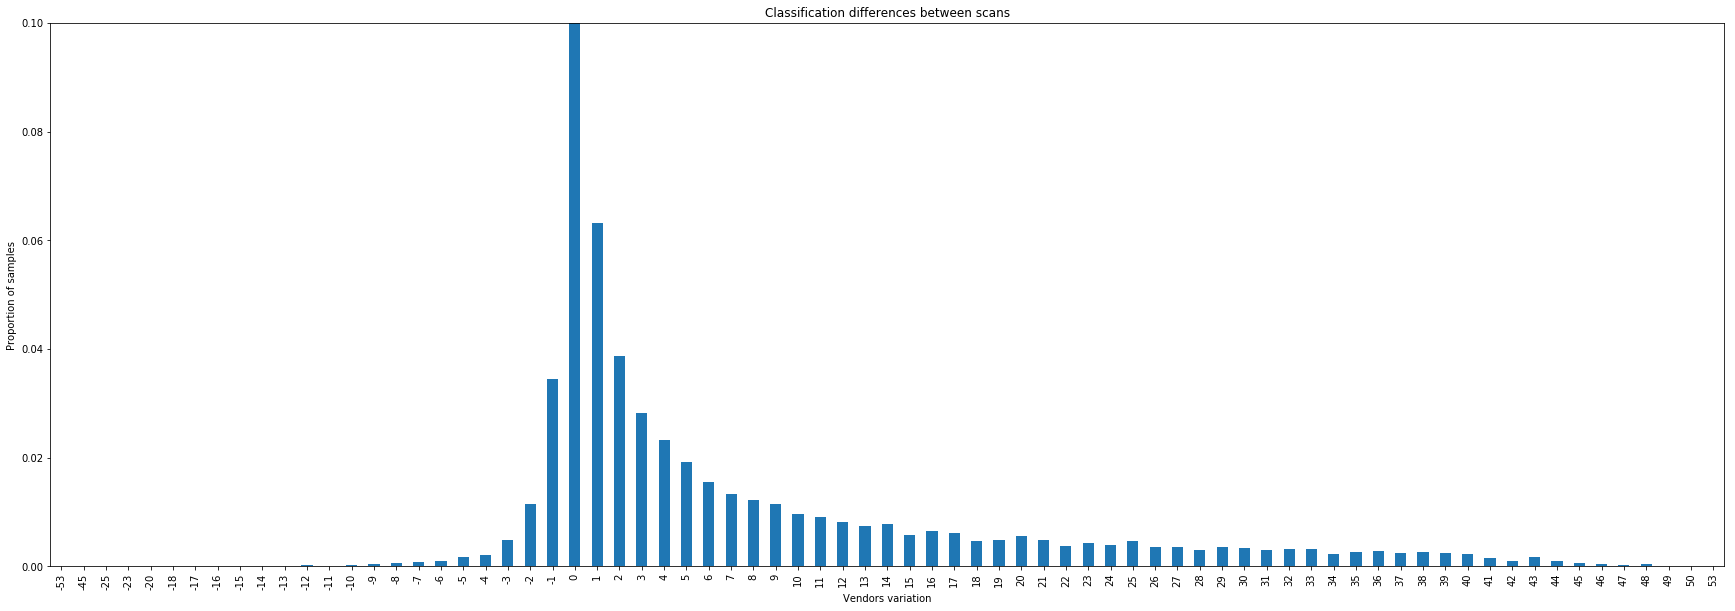

In [10]:
differences_ratio = differences_count.divide(differences_count.sum())
ax = differences_ratio.plot.bar(
    figsize=((30, 10)), title='Classification differences between scans',
    ylim=(0, 0.1))
ax.set_xlabel('Vendors variation')
ax.set_ylabel('Proportion of samples')
plt.show()

In [11]:
display('Samples that increased classification: {:.2f}%'.format(
    differences_ratio[differences_ratio.index > 0].sum()*100))
display('Samples that decreased classification: {:.2f}%'.format(
    differences_ratio[differences_ratio.index < 0].sum()*100))

'Samples that increased classification: 37.29%'

'Samples that decreased classification: 5.85%'

The graph is sugestive regarding vendors' tendency for false negatives, as 37% of changes are for the positive side *vs* 5.85% for the negative side.

### Minimum threshold

Given the previous graph, one can now choose a minimum number of positive detections to define a sample as malware.

In [12]:
display('Samples that went from 5 or more vendors to none: {:.2f}%'.format(
    differences_ratio[differences_ratio.index <= -5].sum()*100))
display('Samples that went from 5 or more vendors to one: {:.2f}%'.format(
    differences_ratio[differences_ratio.index <= -4].sum()*100))

'Samples that went from 5 or more vendors to none: 0.56%'

'Samples that went from 5 or more vendors to one: 0.77%'

By choosing a threshold of 5 or more, the percentage of samples that go from 5+ positive classifications to none is lower than 0.56% (these values do not discriminate the final classification, hence a -5 difference may be from 10 to 5 or from 5 to 0).

Using the same principle, the percentage of samples that go from 5+ to 1 (at least -4 change) is lower than 0.77%

### Goodware confidence

For goodware samples (where no vendor classifies it as malware), it is also interesting to understand the statistic regarding samples that go from clean to malware. Specifically, how many of the duplicated samples increase from 0 positive classifications to 5 or more.

In [13]:
%%time
# Calculate the difference between last and first submission for clean samples
clean_differences = []
for md5 in first_last_samples.index.unique():
    temp = first_last_samples[first_last_samples.index == md5].sort_values('date', ascending=False)
    temp = temp[0].values
    if temp[1] == 0:
        clean_differences += [temp[0] - temp[1]]

CPU times: user 3min 34s, sys: 183 ms, total: 3min 34s
Wall time: 3min 34s


In [14]:
clean_differences_count = pd.Series(clean_differences).value_counts().sort_index()
display('{}/{} ({:.2f}%) clean samples changed classification'.format(
    clean_differences_count[clean_differences_count.index != 0].sum(),
    clean_differences_count.sum(),
    100*clean_differences_count[clean_differences_count.index != 0].sum()/clean_differences_count.sum()))

'682/4256 (16.02%) clean samples changed classification'

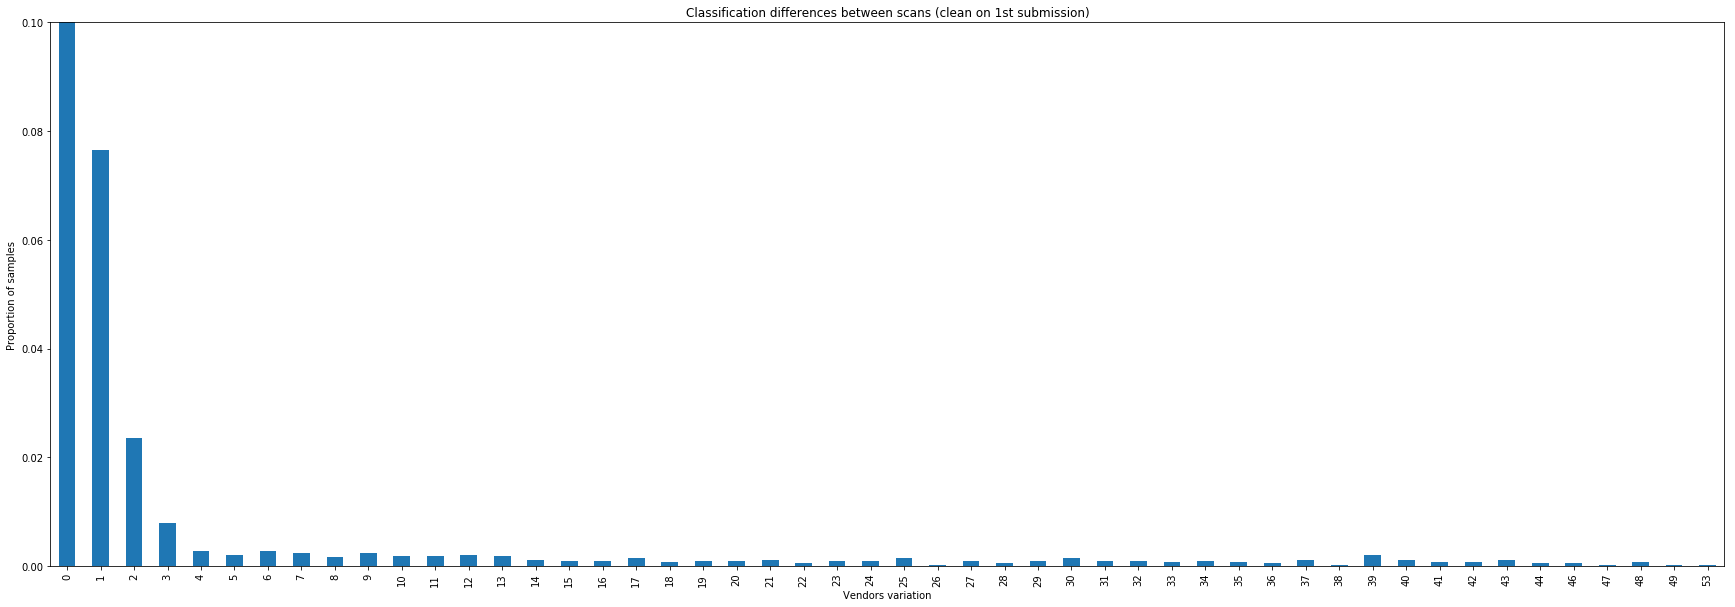

In [15]:
clean_differences_ratio = pd.Series(clean_differences).value_counts().divide(len(clean_differences)).sort_index()
ax = clean_differences_ratio.plot.bar(
    figsize=((30, 10)), title='Classification differences between scans (clean on 1st submission)',
    ylim=(0, 0.1))
ax.set_xlabel('Vendors variation')
ax.set_ylabel('Proportion of samples')
plt.show()

In [16]:
display('Samples that went from clean to 5+ classifications: {:.2f}%'.format(
    100*clean_differences_ratio[clean_differences_ratio.index >= 5].sum()))

'Samples that went from clean to 5+ classifications: 4.93%'

## Conclusion

A sample is classified as malware if at least 5 vendors classify it as malware. The threshold was chosen by looking at the change of classifications for duplicated samples. The likelihood of a sample with 5 or more positive classifications to become clean is residual (0.56%).

Regarding goodware samples, the goodware criteria is that no vendor classifies the sample as malware. Although this is a simple criteria, we've shown that vendors show a tendency for false negatives (higher percentage of samples increasing in number of positive classifications), which raises the question: are we selecting goodware that is marked as a false negative?

By looking at how clean samples change over time, we observe that only 16% of clean samples change classification, and only 4.93% go over the malware threshold (5 or more positive classifications). If the percentage of changes for clean on the first submission samples is low, the 37% increase tendency must be on samples that already have some classification. This observation might suggest a dependency between vendors, as they are more likely to change from negative to positive if some other vendor already marks a sample as positive.